# Visualizatino of a graph
This notebook shows how to create or load a sample graph.
It then visualizes it and computes the presented metrics of inequality, segregation and inequity.

## Imports and configuration

In [1]:
import os
import json

import matplotlib.pyplot as plt
import networkx as nx

from patch_workshop.utils import create_graph, create_file_name
from patch_workshop.inequality_metrics import\
    compute_gini, compute_stoch_dom
from patch_workshop.homophily_metrics import compute_ei_index
from patch_workshop.constants import LFM_RANDOM, LFM_HOMOPHILY, LFM_PAH
from patch_workshop.stats import compute_cdf

In [2]:
SEED = 5 # Fix seed for reproducibility
PATH_GRAPHS = "../data/graphs/"

In [15]:
N = 200
m = 2
F_M = 0.3
H = 0.8
TC = 0.0
LFM_GLOBAL = LFM_PAH
LFM_LOCAL = LFM_PAH

## Loading a graph

In [16]:
file_path = os.path.join(
    PATH_GRAPHS,
    create_file_name(
        N=N, m=m,
        minority_fraction=F_M,
        homophily=H,
        triadic_closure=TC,
        lfm_global=LFM_GLOBAL,
        lfm_local=LFM_LOCAL,
        realization=0))
print(f"Loading graph from {file_path}")
graph_loaded = None
with open(file_path, "r") as f:
    graph_loaded = json.load(f)
graph_loaded = nx.node_link_graph(
    data=graph_loaded, directed=False, multigraph=False)
print(graph_loaded)

Loading graph from ../data/graphs/N-200_m-2_f-0.3_h-0.8_tc-0.8_lfm-l-pah_lfm-g-pah_r-0.json
Graph with 200 nodes and 397 edges


## Statistics
Compute the network characteristics.

In [17]:
nodes_min = set([n for n, d in graph_loaded.nodes(data=True) if d["m"]])

gini = compute_gini(graph_loaded)
ei_index = compute_ei_index(graph_loaded, nodes_min=nodes_min)
stoch_dom = compute_stoch_dom(graph_loaded, minority_nodes=nodes_min)

print(f"Gini: {gini}")
print(f"EI index: {ei_index}")
print(f"Stochastic dominance: {stoch_dom}")

Gini: 0.42318639798488666
EI index: -0.5465994962216625
Stochastic dominance: 0.008452380952380878


## Creating a graph
First, we simulate a graph using our own parameters

In [18]:
graph_created = create_graph(
    N=N, # Number of nodes
    m=m, # Number of edges per new node
    f_m=F_M, # Minority fraction
    h=H, # Homophily value
    tc=TC, # Change of the edges (starting from second) to be local (triadic closure)
    lfm_global=LFM_PAH, lfm_local=LFM_PAH, # Link formation mechanisms for local and global links
    seed=SEED)
print(graph_created)

PATCH with 200 nodes and 397 edges


In [19]:
nodes_min = set([n for n in graph_created.nodes if graph_created.nodes[n]['m']])

gini = compute_gini(graph_created)
ei_index = compute_ei_index(graph_created, nodes_min=nodes_min)
stoch_dom = compute_stoch_dom(graph_created, minority_nodes=nodes_min)

print(f"Gini: {gini}")
print(f"EI index: {ei_index}")
print(f"Stochastic dominance: {stoch_dom}")

Gini: 0.42870277078085645
EI index: -0.5768261964735516
Stochastic dominance: 0.023809523809523947


## Visualizing a graph

Visualize this graph using NetworkX (see [docs](https://networkx.org/documentation/stable/reference/drawing.html)).

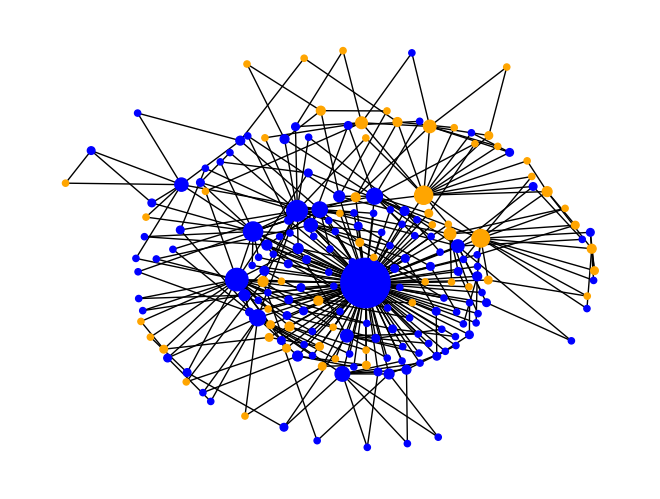

In [20]:
layout = nx.kamada_kawai_layout(graph_created)
nx.draw(
    graph_created, layout,
    node_color=["orange" if graph_created.nodes[n]['m'] else "blue"\
        for n in graph_created.nodes],
    node_size=[10*k for _, k in graph_created.degree()])

 Visualize the underlying degree distribution.
 As the degree distributions typically follow a [power law distribution](https://en.wikipedia.org/wiki/Power_law), we use a log-log scaling of the axes and plot the [complementary cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function#Complementary_cumulative_distribution_function_(tail_distribution)) (CCDF) to visualize the distribution's tail.
 Those are nodes with extreme degree values, so called [hubs](https://en.wikipedia.org/wiki/Hub_(network_science)). 
 The CCDF shows the fraction of nodes that exceed the given degree (x-axis).

Text(0, 0.5, 'CCDF')

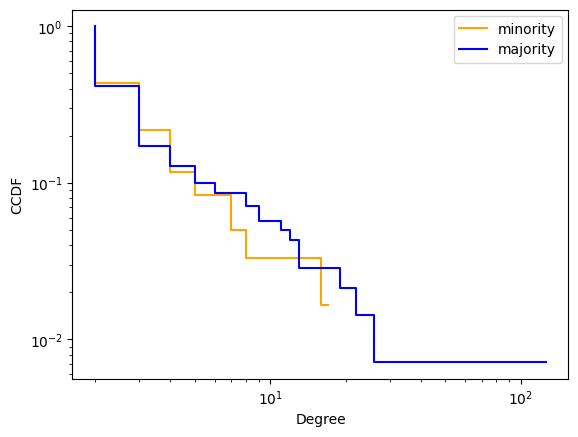

In [21]:
a_k_min, a_y_min = compute_cdf(
    [k for node, k in graph_created.degree() if graph_created.nodes[node]["m"]])
a_k_maj, a_y_maj = compute_cdf(
    [k for node, k in graph_created.degree() if not graph_created.nodes[node]["m"]])
plt.step(a_k_min, 1 - a_y_min, color="orange", label="minority")
plt.step(a_k_maj, 1 - a_y_maj, color="blue", label="majority")

plt.xscale("log")
plt.yscale("log")

plt.legend()
plt.xlabel("Degree")
plt.ylabel("CCDF")